Importing Modules

In [1]:
EXPERIMENT_ID = 303
LOSS_TYPE='kl'
LOSS_REDUCTION='batchmean' #'sum','mean'
SIGMOID_ACT=True
MSE_PLUS_MINUS='+'
APPLY_SPARSITY_TO='bottleneck' #all

In [2]:
epochs = 20  # args['epochs']
reg_param = 0.001  # args['reg_param']
add_sparsity = 'yes'  # args['add_sparse']
learning_rate = 1e-4
batch_size = 32
print(f"Add sparsity regularization: {add_sparsity}")

Add sparsity regularization: yes


In [3]:
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
import sys, importlib as impL
import pandas as pd

In [4]:
import socket
def get_var_by_comp_name(variableName):
    curCompName = socket.gethostname()
    retVal = None
    if variableName == 'khs_dir':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/home/wsubuntu/GitHub/keyhandshapediscovery'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'data_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/Datasets'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/media/wsubuntu/SSD_Data/DataPath'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'experiment_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery/experiments/SPARSE_TORCH'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/media/wsubuntu/SSD_Data/vaesae_experiments'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
        
    print(curCompName + '_' + variableName, '=',  retVal)
    if retVal is None:
        os.error(5)
    return retVal

khs_dir = get_var_by_comp_name('khs_dir')
data_path = get_var_by_comp_name('data_path')
experiment_path = get_var_by_comp_name('experiment_path')

wsubuntu_khs_dir = /home/wsubuntu/GitHub/keyhandshapediscovery
wsubuntu_data_path = /media/wsubuntu/SSD_Data/DataPath
wsubuntu_experiment_path = /media/wsubuntu/SSD_Data/vaesae_experiments


In [5]:
sys.path.insert(1, khs_dir)
import helperFuncs as funcH

In [6]:
def calc_bottleneck_acc(bottleneck_vec, lab_vec):
    pred_vec = np.argmax(bottleneck_vec.T, axis=0).T.squeeze()
    centroid_info_pdf = funcH.get_cluster_centroids(bottleneck_vec, pred_vec, kluster_centers=None, verbose=0)
    _confMat_preds, kluster2Classes, kr_pdf, weightedPurity, cnmxh_perc = funcH.countPredictionsForConfusionMat(lab_vec, pred_vec, centroid_info_pdf=centroid_info_pdf, labelNames=None)
    sampleCount = np.sum(np.sum(_confMat_preds))
    acc = 100 * np.sum(np.diag(_confMat_preds)) / sampleCount
    bmx, bmn = np.max(bottleneck_vec), np.min(bottleneck_vec)
    return acc, bmx, bmn

funcH.setPandasDisplayOpts()

Constructing the Argument Parsers

here I will change the data loader per my need

In [7]:
# get the computation device
def get_device():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cpu


In [8]:
# image transformations
transform = transforms.Compose([transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

FOLDERS = {
    "data": data_path,
    "experiment": os.path.join(experiment_path, 'sparse_torch_ae_' + str(EXPERIMENT_ID).zfill(3)),
}
FOLDERS["model_save"] = os.path.join(FOLDERS["experiment"], "model")
FOLDERS["decoder_image_path_tr"] = os.path.join(FOLDERS["experiment"], "output_images_tr")
FOLDERS["decoder_image_path_va"] = os.path.join(FOLDERS["experiment"], "output_images_va")
funcH.createDirIfNotExist(FOLDERS["model_save"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_tr"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_va"])

trainset = datasets.CIFAR10(
    root=FOLDERS["data"],
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.CIFAR10(
    root=FOLDERS["data"],
    train=False,
    download=True,
    transform=transform
)
 
# trainloader
trainloader = DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True
)
#testloader
testloader = DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified


In [53]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, loss_type):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.enc2 = nn.MaxPool2d(kernel_size=2)
        self.enc3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.enc4 = nn.Linear(in_features=32 * 10 * 10, out_features=256)
        self.enc5 = nn.Linear(in_features=256, out_features=64)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=64, out_features=256)
        self.dec2 = nn.Linear(in_features=256, out_features=32*10*10)
        self.dec3 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5)
        self.dec4 = nn.Upsample(scale_factor=2)
        self.dec5 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=5)
        
        self.loss_type=loss_type
        self.device = get_device()

    def encode(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        #print("after Conv1:",x.shape)
        x = self.enc2(x)
        #print("after maxpool:",x.shape)
        x = F.relu(self.enc3(x))
        #print("after Conv2:",x.shape)
        x = x.view(-1, 32 * 10 * 10)
        #print("after reshape:",x.shape)
        x = F.relu(self.enc4(x))
        #print("after Lin1:",x.shape)
        bottleneck = F.relu(self.enc5(x))  
        #print("bottleneck:",bottleneck.shape)
        return bottleneck
        
    def decode(self, bottleneck):
        # decoding
        x = F.relu(self.dec1(bottleneck))
        #print("after Linear-1:",x.shape)
        x = F.relu(self.dec2(x))
        #print("after Linear-2:",x.shape)
        x = x.view(-1, 32, 10, 10)
        #print("after reshape:",x.shape)
        x = F.relu(self.dec3(x))
        #print("after ConvTranspose2d:",x.shape)
        x = self.dec4(x)
        #print("after Upsample:",x.shape)
        x = F.relu(self.dec5(x)) 
        #print("after all:",x.shape)
        return x
        
    def forward(self, x):
        bottleneck = self.encode(x)
        x = self.decode(bottleneck)
        return x, bottleneck

model = SparseAutoencoder(loss_type=LOSS_TYPE).to(device)

In [54]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [55]:
# get the layers as a list
model_children = list(model.children())
[print(i) for i in model_children]

Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
Linear(in_features=3200, out_features=256, bias=True)
Linear(in_features=256, out_features=64, bias=True)
Linear(in_features=64, out_features=256, bias=True)
Linear(in_features=256, out_features=3200, bias=True)
ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
Upsample(scale_factor=2.0, mode=nearest)
ConvTranspose2d(16, 3, kernel_size=(5, 5), stride=(1, 1))


[None, None, None, None, None, None, None, None, None, None]

In [56]:
def loss_l1(bottleneck):
    return torch.mean(torch.abs(bottleneck))

def loss_l2(bottleneck):
    return torch.mean(torch.pow(bottleneck, torch.tensor(2.0).to(device))).sqrt()

def kl_divergence(bottleneck, reduction):
    rho = 0.0625
    bt = torch.mean(torch.sigmoid(bottleneck), 1)  # sigmoid because we need the probability distributions
    rho = torch.tensor([rho] * len(bt)).to(device)
    loss_ret_1 = torch.nn.functional.kl_div(bt, rho, reduction=reduction)
    # torch.sum(rho * torch.log(rho / bottleneck) + (1 - rho) * torch.log((1 - rho) / (1 - bottleneck)))
    return loss_ret_1

def loss_crossentropy(bottleneck, sigmoidAct, reduction):
    loss_fun = torch.nn.CrossEntropyLoss(reduction=reduction)
    if sigmoidAct:
        bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    else:
        bt = bottleneck    
    _, preds = torch.max(bt, 1)
    loss_ret_1 = loss_fun(bt, preds)    
    return loss_ret_1

In [57]:
# define the sparse loss function
def sparse_loss(autoencoder, images, print_info, loss_type):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        #if print_info:
            #print(i, ' shape=', values.shape)
        if loss_type=='l1':
            loss += loss_l1(values)
        if loss_type=='l2':
            loss += loss_l2(values)
        if loss_type=='kl':
            loss += kl_divergence(values, reduction=LOSS_REDUCTION)
        if loss_type=='cre':
            loss += loss_crossentropy(values, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
        if print_info:
            print(loss_type,loss)
    return loss

def sparse_loss_bottleneck(bottleneck, print_info, loss_type):
    loss = 0
    #if print_info:
        #print(i, ' shape=', values.shape)
    if loss_type=='l1':
        loss += loss_l1(bottleneck)
    if loss_type=='l2':
        loss += loss_l2(bottleneck)
    if loss_type=='kl':
        loss += kl_divergence(bottleneck, reduction=LOSS_REDUCTION)
    if loss_type=='cre':
        loss += loss_crossentropy(bottleneck, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
    if print_info:
        print(loss_type,loss)
    return loss

In [58]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 32, 32)
    save_image(img, name)

# define the training function
def fit(model, dataloader, epoch, print_losses_fit):
    print('TrEpoch({:03d}) - '.format(epoch), end='')
    model.train()
    running_loss = 0.0
    
    lab_vec = []
    bottleneck_vec = []
    sparsity_loss_sum = 0
    mse_sum = 0
       
    for data in dataloader:
        img, lb = data
        lab_vec.append(lb)
        
        img = img.to(device)
        #img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs, bottleneck = model(img)
        bottleneck_vec.append(bottleneck)
        if print_losses_fit:
            print("outputs:", outputs.shape)
            print("img:", img.shape)
        mse_loss = criterion(outputs, img)
        mse_sum += mse_loss.item()
        #if print_losses_fit:
            #print("mse_loss:", mse_loss.to('cpu'))
            #print("bottleneck:", bottleneck.to('cpu'))
        if add_sparsity == 'yes':
            if APPLY_SPARSITY_TO=='all':
                sp_loss = sparse_loss(model, img, print_losses_fit, model.loss_type)
            elif APPLY_SPARSITY_TO=='bottleneck': #all
                sp_loss = sparse_loss_bottleneck(bottleneck, print_losses_fit, model.loss_type)
            else:
                os.exit(4)
                
            sparsity_loss_sum += sp_loss.item()
            
            # add the sparsity penalty
            if print_losses_fit:
                print("sp_loss:", sparsity_loss_sum)
                
            if MSE_PLUS_MINUS=='-':
                loss = mse_loss - reg_param * sp_loss
            elif MSE_PLUS_MINUS=='+':
                loss = mse_loss + reg_param * sp_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print_losses_fit = False
    
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)
    #print("tr bottleneck accuracy=", acc, ", max=", bmx, ", min=", bmn, ", sparsity_loss_sum=", sparsity_loss_sum)
  
    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, mse_sum, sparsity_loss_sum, running_loss]]), columns=['acc','bmx','bmn','mse','spr','run'])
    #print(df.iloc[0]['mse']) #'acc','bmx','bmn','mse','spr','run'
    print("\n",result_df)
    if epoch % 2 == 0:
        difn = os.path.join(FOLDERS["decoder_image_path_tr"], "train"+str(epoch).zfill(3)+".png")
        save_decoded_image(outputs.cpu().data, difn)
    return result_df

In [59]:
# define the validation function
def validate(model, dataloader, epoch, print_losses_fit):
    print('ValEpoch({:03d}) - '.format(epoch), end='')
    model.eval()
    running_loss = 0.0
    lab_vec = []
    bottleneck_vec = []
    with torch.no_grad():
        for data in dataloader:
            img, lb = data
            lab_vec.append(lb)
            img = img.to(device)
            #img = img.view(img.size(0), -1)
            outputs, bottleneck = model(img)
            bottleneck_vec.append(bottleneck)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    # save the reconstructed images every 5 epochs
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)

    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, running_loss]]), columns=['acc','bmx','bmn','run'])
    print("\n",result_df)
    
    if epoch % 2 == 0:
        outputs = outputs.view(outputs.size(0), 3, 32, 32).cpu().data
        difn = os.path.join(FOLDERS["decoder_image_path_va"], "reconstruction"+str(epoch).zfill(3)+".png")
        save_image(outputs, difn)
    return result_df

In [60]:
# train and validate the autoencoder neural network
start = time.time()
print_losses_fit = True

train_loss = []
trn_spars_loss = []
trn_bot_acc = []
val_loss = []
val_bot_acc = []

result_df_tr_all = pd.DataFrame(columns=['acc','bmx','bmn','mse','spr','run'])
result_df_va_all = pd.DataFrame(columns=['acc','bmx','bmn','run'])

print("stae_ws05 :: ")
print("EXPERIMENT_ID: ", EXPERIMENT_ID)
print("LOSS_TYPE : ", LOSS_TYPE)
print("LOSS_REDUCTION : ", LOSS_REDUCTION)
print("SIGMOID_ACT : ", SIGMOID_ACT)
print("APPLY_SPARSITY_TO : ", APPLY_SPARSITY_TO)
print("total loss = mse_loss " + MSE_PLUS_MINUS + " reg_param * sp_loss")

for epoch in range(epochs):
    print(f"*****\n Epoch {epoch} of {epochs}")
    result_df_tr = fit(model, trainloader, epoch, print_losses_fit)
    result_df_va = validate(model, testloader, epoch, print_losses_fit)
    print_losses_fit = epoch%5==0 and epoch>0
    result_df_tr_all = result_df_tr_all.append(result_df_tr, ignore_index=True)
    result_df_va_all = result_df_va_all.append(result_df_va, ignore_index=True)
    
end = time.time()
 
print(f"{(end-start)/60:.3} minutes")
# save the trained model

mofn = os.path.join(FOLDERS["model_save"], "sparse_ae_"+str(epoch).zfill(3)+".pth")
torch.save(model.state_dict(), mofn)

stae_ws05 :: 
EXPERIMENT_ID:  303
LOSS_TYPE :  kl
LOSS_REDUCTION :  batchmean
SIGMOID_ACT :  True
APPLY_SPARSITY_TO :  bottleneck
total loss = mse_loss + reg_param * sp_loss
*****
 Epoch 0 of 20
TrEpoch(000) - outputs: torch.Size([32, 3, 32, 32])
img: torch.Size([32, 3, 32, 32])
kl tensor(-0.2048, grad_fn=<AddBackward0>)
sp_loss: -0.2048429250717163

       acc    bmx  bmn      mse      spr     run
0  14.074  15.83  0.0  290.951 -341.219  290.61
ValEpoch(000) - 
      acc     bmx  bmn     run
0  11.93  13.018  0.0  52.607
*****
 Epoch 1 of 20
TrEpoch(001) - 
       acc     bmx  bmn      mse      spr      run
0  16.082  12.956  0.0  261.588 -345.791  261.242
ValEpoch(001) - 
      acc    bmx  bmn     run
0  14.98  11.59  0.0  50.714
*****
 Epoch 2 of 20
TrEpoch(002) - 
       acc     bmx  bmn      mse      spr      run
0  12.366  11.506  0.0  255.564 -345.744  255.218
ValEpoch(002) - 
      acc     bmx  bmn     run
0  17.25  10.588  0.0  49.896
*****
 Epoch 3 of 20
TrEpoch(003) - 
     

In [61]:
print(result_df_tr_all)

       acc     bmx  bmn      mse      spr      run
0   14.074  15.830  0.0  290.951 -341.219  290.610
1   16.082  12.956  0.0  261.588 -345.791  261.242
2   12.366  11.506  0.0  255.564 -345.744  255.218
3   17.200  10.735  0.0  252.348 -345.541  252.002
4   15.768  10.117  0.0  250.331 -345.370  249.986
5   16.138  10.009  0.0  248.966 -345.371  248.620
6   14.482   9.665  0.0  247.971 -345.379  247.626
7   15.882   9.255  0.0  247.179 -345.267  246.834
8   15.614   9.195  0.0  246.574 -345.323  246.229
9   15.512   9.289  0.0  246.196 -345.338  245.851
10  15.426   9.223  0.0  245.880 -345.301  245.535
11  15.204   9.263  0.0  245.678 -345.263  245.333
12  15.738   9.013  0.0  245.502 -345.217  245.157
13  15.706   8.978  0.0  245.295 -345.259  244.950
14  15.274   8.958  0.0  245.163 -345.215  244.818
15  14.742   9.055  0.0  245.002 -345.357  244.657
16  13.724   9.111  0.0  244.815 -345.543  244.469
17  14.098   8.929  0.0  244.649 -345.804  244.303
18  14.314   8.929  0.0  244.52

In [62]:
print(result_df_va_all)

      acc     bmx  bmn     run
0   11.93  13.018  0.0  52.607
1   14.98  11.590  0.0  50.714
2   17.25  10.588  0.0  49.896
3   16.69  10.073  0.0  49.441
4   13.51   9.875  0.0  49.066
5   13.87   9.526  0.0  48.843
6   16.03   9.423  0.0  48.668
7   16.13   9.575  0.0  48.545
8   16.12   9.509  0.0  48.432
9   15.45   9.372  0.0  48.410
10  14.98   9.235  0.0  48.356
11  15.24   9.210  0.0  48.299
12  16.50   9.129  0.0  48.273
13  17.01   9.033  0.0  48.230
14  15.90   8.993  0.0  48.188
15  17.02   9.056  0.0  48.213
16  16.03   8.838  0.0  48.143
17  15.54   8.703  0.0  48.138
18  15.86   8.762  0.0  48.088
19  16.71   8.639  0.0  48.062


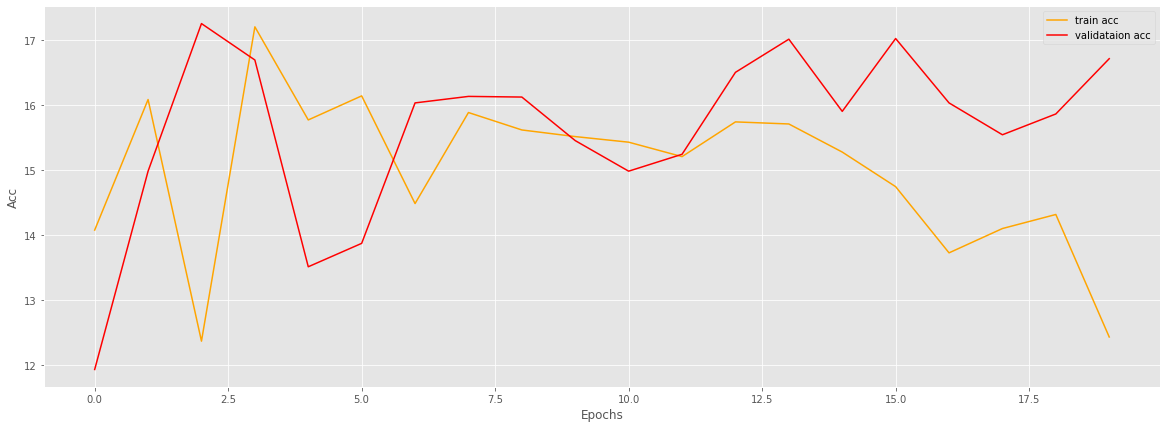

Max tr acc =  17.2
Max va acc =  17.25


In [63]:
tr_acc = result_df_tr_all.values[:,0].squeeze()
va_acc = result_df_va_all.values[:,0].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_acc, color='orange', label='train acc')
plt.plot(va_acc, color='red', label='validataion acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()
print("Max tr acc = ", np.max(tr_acc))
print("Max va acc = ", np.max(va_acc))

all(290.95), trmse(1.00), trspr(0.00), vaerr(5.00)


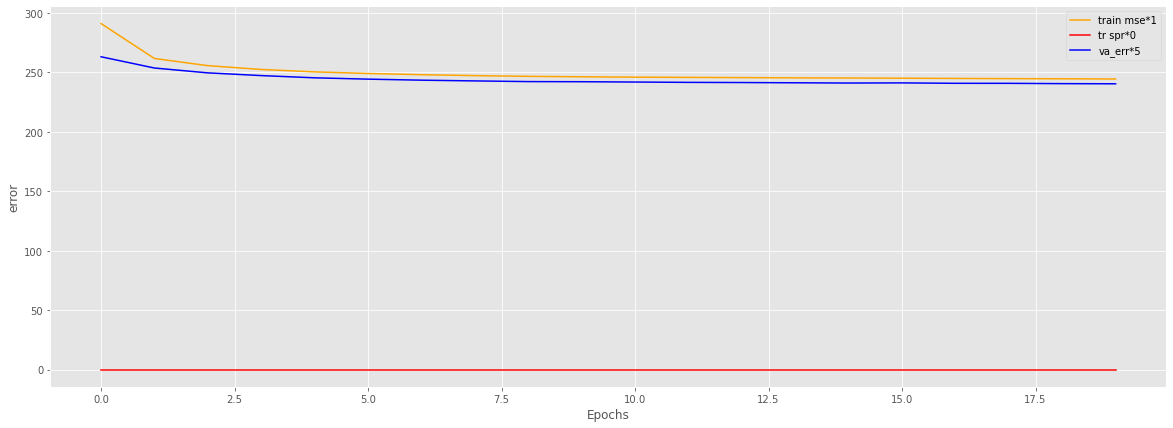

In [65]:
tr_mse = result_df_tr_all.values[:,3].squeeze()
tr_spr = result_df_tr_all.values[:,4].squeeze()
va_err = result_df_va_all.values[:,-1].squeeze()

mx_all = np.max([tr_mse, tr_spr, va_err])
tr_mse_mul = int(mx_all/np.max(tr_mse))
tr_spr_mul = int(mx_all/np.max(tr_spr))
va_err_mul = int(mx_all/np.max(va_err))
print("all({:.2f}), trmse({:.2f}), trspr({:.2f}), vaerr({:.2f})".format(mx_all, tr_mse_mul, tr_spr_mul, va_err_mul))

plt.figure(figsize=(20, 7))
plt.plot(tr_mse*tr_mse_mul, color='orange', label='train mse*'+str(tr_mse_mul))
plt.plot(tr_spr*tr_spr_mul, color='red', label='tr spr*'+str(tr_spr_mul))
plt.plot(va_err*va_err_mul, color='blue', label='va_err*'+str(va_err_mul))
plt.xlabel('Epochs')
plt.ylabel('error')
plt.legend()
plt.show()